In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor

In [219]:
file_path = "/kaggle/input/fesmarodatasets/Dataset Kedua - Dataset Kedua.csv"
df = pd.read_csv(file_path,low_memory=False)


**PREPROCESSING**

In [220]:
numeric_columns = [
    "Benefit per order", "Sales per customer", "Order Item Discount", 
    "Order Item Discount Rate", "Order Item Product Price", "Order Item Profit Ratio", 
    "Sales", "Order Item Total", "Order Profit Per Order", "Product Price"
]

for col in numeric_columns:
    df[col] = df[col].astype(str).str.replace('.', '', regex=False).str.replace(',', '.', regex=False)
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Mengubah kolom tanggal ke format datetime
df['order date (DateOrders)'] = pd.to_datetime(df['order date (DateOrders)'], errors='coerce')
df['shipping date (DateOrders)'] = pd.to_datetime(df['shipping date (DateOrders)'], errors='coerce')

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Type                           180519 non-null  object        
 1   Days for shipping (real)       180519 non-null  int64         
 2   Days for shipment (scheduled)  180519 non-null  int64         
 3   Benefit per order              180519 non-null  int64         
 4   Sales per customer             180519 non-null  int64         
 5   Delivery Status                180519 non-null  object        
 6   Late_delivery_risk             180519 non-null  int64         
 7   Category Id                    180519 non-null  int64         
 8   Category Name                  180519 non-null  object        
 9   Customer City                  180519 non-null  object        
 10  Customer Country               180519 non-null  object        
 11  

**KETERLAMBATAN PENGIRIMAN**

In [221]:
# Menghitung tingkat keterlambatan pengiriman
late_delivery_count = df['Late_delivery_risk'].sum()
total_orders = len(df)
late_delivery_percentage = (late_delivery_count / total_orders) * 100

# Perbandingan Waktu Pengiriman Real vs. Terjadwal
df['Shipping Delay'] = df['Days for shipping (real)'] - df['Days for shipment (scheduled)']
average_shipping_delay = df['Shipping Delay'].mean()

# Efektivitas Shipping Mode terhadap keterlambatan
shipping_mode_delay = df.groupby('Shipping Mode')['Late_delivery_risk'].mean()

# Distribusi Status Pengiriman
delivery_status_distribution = df['Delivery Status'].value_counts()

# Efisiensi Logistik per Wilayah
region_delay = df.groupby('Order Region')['Late_delivery_risk'].mean()
state_delay = df.groupby('Order State')['Late_delivery_risk'].mean()

# Menampilkan hasil analisis
print(f"Total Orders: {total_orders}")
print(f"Late Deliveries: {late_delivery_count}")
print(f"Late Delivery Percentage: {late_delivery_percentage:.2f}%")
print(f"Average Shipping Delay: {average_shipping_delay:.2f} days")

Total Orders: 180519
Late Deliveries: 98977
Late Delivery Percentage: 54.83%
Average Shipping Delay: 0.57 days


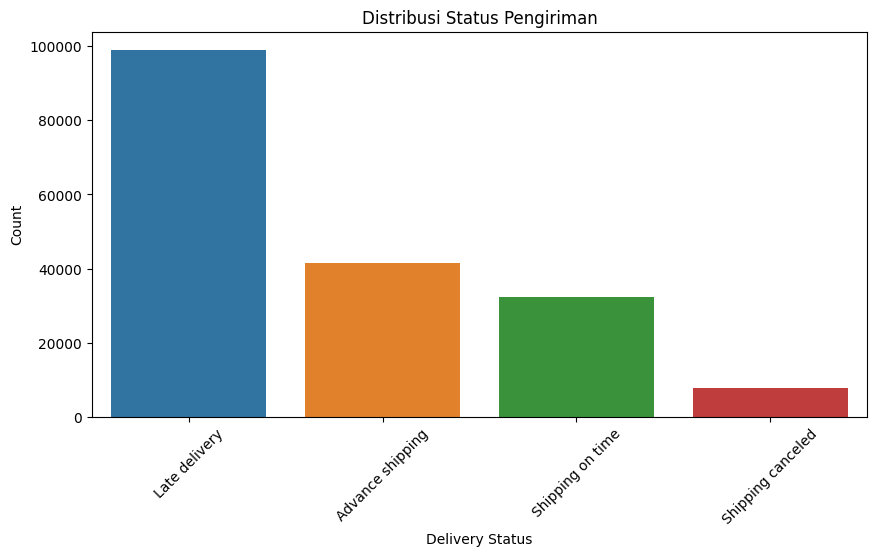

In [222]:
# Visualisasi distribusi status pengiriman
plt.figure(figsize=(10,5))
sns.barplot(x=delivery_status_distribution.index, y=delivery_status_distribution.values)
plt.title('Distribusi Status Pengiriman')
plt.xlabel('Delivery Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

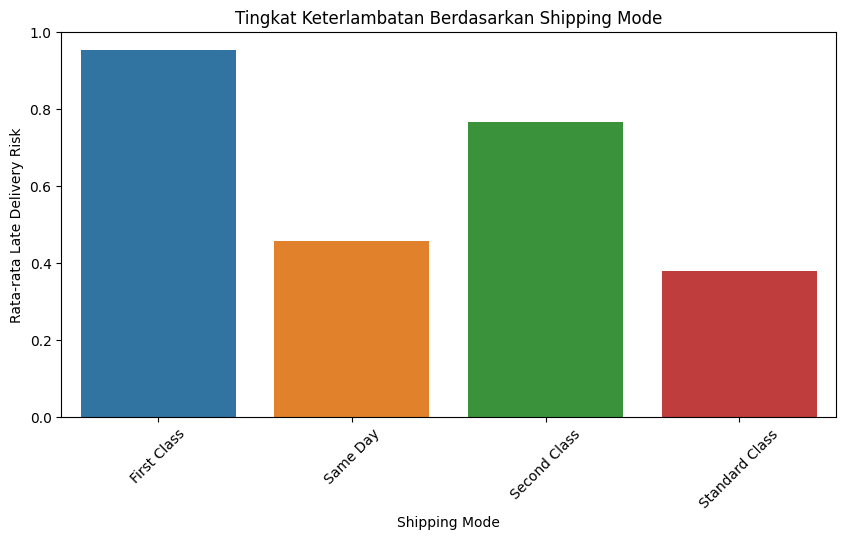

In [254]:
# Visualisasi keterlambatan berdasarkan Shipping Mode
plt.figure(figsize=(10,5))
sns.barplot(x=shipping_mode_delay.index, y=shipping_mode_delay.values)
plt.title('Tingkat Keterlambatan Berdasarkan Shipping Mode')
plt.xlabel('Shipping Mode')
plt.ylabel('Rata-rata Late Delivery Risk')
plt.xticks(rotation=45)
plt.show()


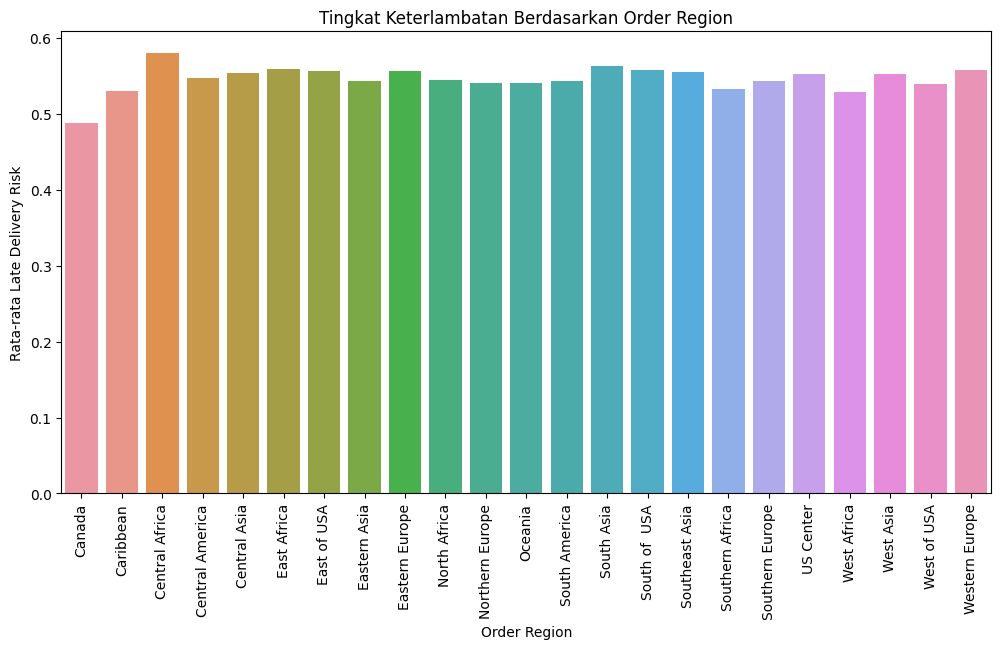

In [252]:
# Visualisasi keterlambatan per wilayah
plt.figure(figsize=(12,6))
sns.barplot(x=region_delay.index, y=region_delay.values)
plt.title('Tingkat Keterlambatan Berdasarkan Order Region')
plt.xlabel('Order Region')
plt.ylabel('Rata-rata Late Delivery Risk')
plt.xticks(rotation=90)
plt.show()


**PROFITABILITAS**

In [263]:
# Profitabilitas per Order
average_profit_per_order = df['Order Profit Per Order'].mean()

# Keuntungan per Produk/Kategori
category_profit = df.groupby('Category Name')['Order Profit Per Order'].sum().sort_values(ascending=False)
product_profit = df.groupby('Product Name')['Order Profit Per Order'].sum().sort_values(ascending=False)

# Dampak Diskon terhadap Profit
discount_vs_profit_corr = df[['Order Item Discount', 'Order Item Discount Rate', 'Order Profit Per Order']].corr()

# Analisis Tren Penjualan
df['Order Date'] = pd.to_datetime(df['shipping date (DateOrders)'], errors='coerce')
sales_trend = df.groupby(df['Order Date'].dt.to_period("M"))['Sales per customer'].sum()
top_selling_product = df.groupby('Product Name')['Order Item Quantity'].sum().sort_values(ascending=False)

# Kategori Produk Terlaris berdasarkan jumlah pesanan
top_selling_category = df['Category Name'].value_counts()

# Produk dengan Keuntungan Tertinggi berdasarkan Order Item Profit Ratio
top_profit_product = df.groupby('Product Name')['Order Item Profit Ratio'].mean().sort_values(ascending=False)

# Ketersediaan Produk: Jumlah produk yang tidak tersedia (Product Status = 1)
unavailable_products = df[df['Product Status'] == 1]['Product Name'].nunique()

# Menampilkan hasil analisis
print(f"Produk Terlaris: {top_selling_product.idxmax()} dengan {top_selling_product.max()} unit terjual")
print(f"Kategori Terlaris: {top_selling_category.idxmax()} dengan {top_selling_category.max()} pesanan")
print(f"Produk dengan Keuntungan Tertinggi: {top_profit_product.idxmax()} dengan profit ratio {top_profit_product.max():.2f}")
print(f"Jumlah Produk yang Tidak Tersedia: {unavailable_products}")
print(f"Average Profit Per Order: {average_profit_per_order:.2f}")
print(f"Top Profitable Category: {category_profit.idxmax()} ({category_profit.max():.2f})")
print(f"Top Profitable Product: {product_profit.idxmax()} ({product_profit.max():.2f})")


Produk Terlaris: Perfect Fitness Perfect Rip Deck dengan 73698 unit terjual
Kategori Terlaris: Cleats dengan 24551 pesanan
Produk dengan Keuntungan Tertinggi: Polar FT4 Heart Rate Monitor dengan profit ratio 220800000.45
Jumlah Produk yang Tidak Tersedia: 0
Average Profit Per Order: 2297705578.85
Top Profitable Category: Cleats (62743851626155.00)
Top Profitable Product: Perfect Fitness Perfect Rip Deck (62666372402712.00)


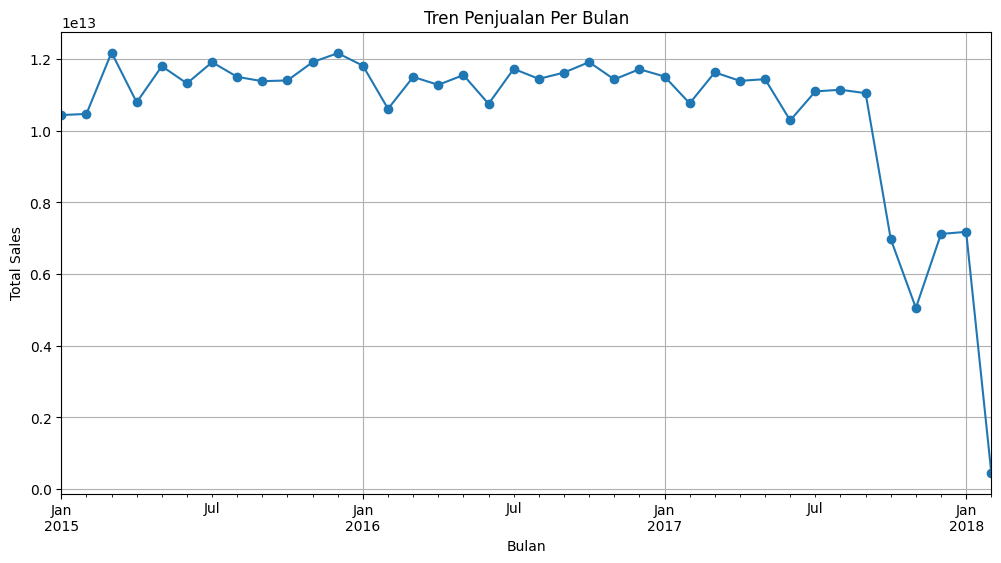

In [228]:
# Visualisasi Tren Penjualan
plt.figure(figsize=(12,6))
sales_trend.plot(kind='line', marker='o')
plt.title('Tren Penjualan Per Bulan')
plt.xlabel('Bulan')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

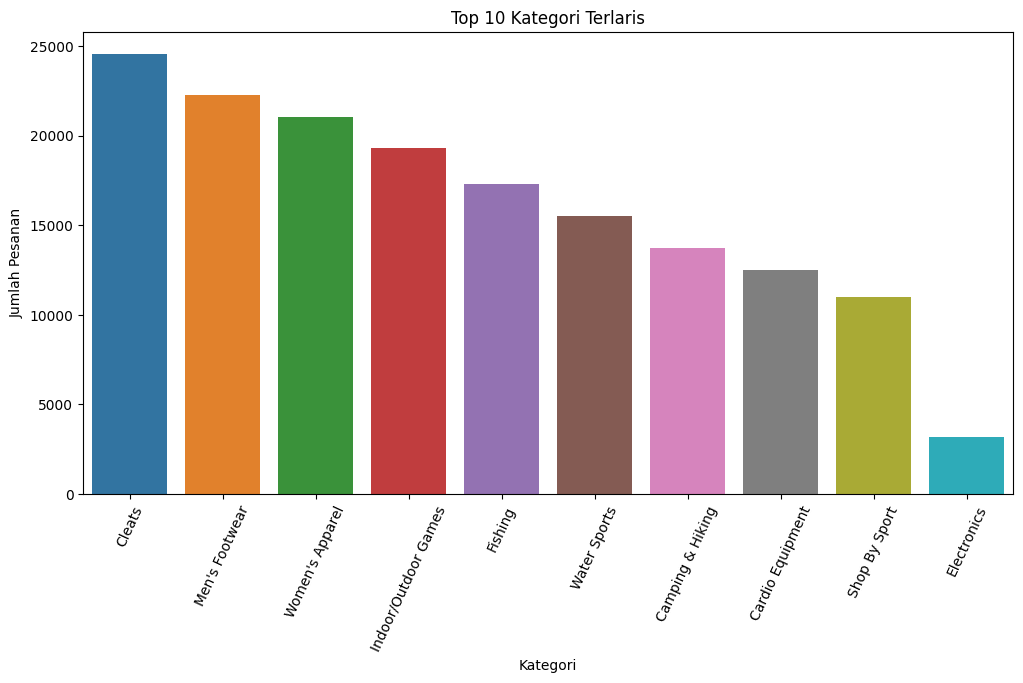

In [262]:
# Visualisasi Kategori Produk Terlaris
plt.figure(figsize=(12,6))
sns.barplot(x=top_selling_category.index[:10], y=top_selling_category.values[:10])
plt.title('Top 10 Kategori Terlaris')
plt.xlabel('Kategori')
plt.ylabel('Jumlah Pesanan')
plt.xticks(rotation=65)
plt.show()

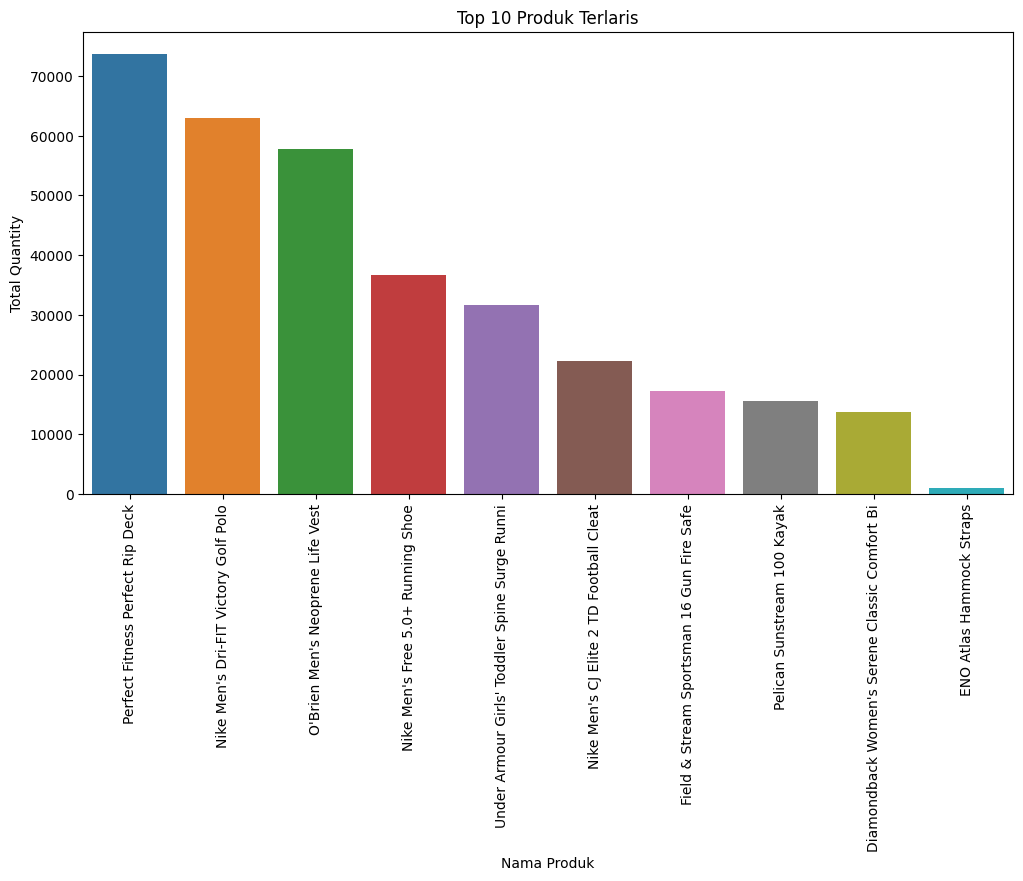

In [261]:
# Visualisasi Produk Terlaris
plt.figure(figsize=(12,6))
sns.barplot(x=top_selling_product.index[:10], y=top_selling_product.values[:10])
plt.title('Top 10 Produk Terlaris')
plt.xlabel('Nama Produk')
plt.ylabel('Total Quantity')
plt.xticks(rotation=90)
plt.show()

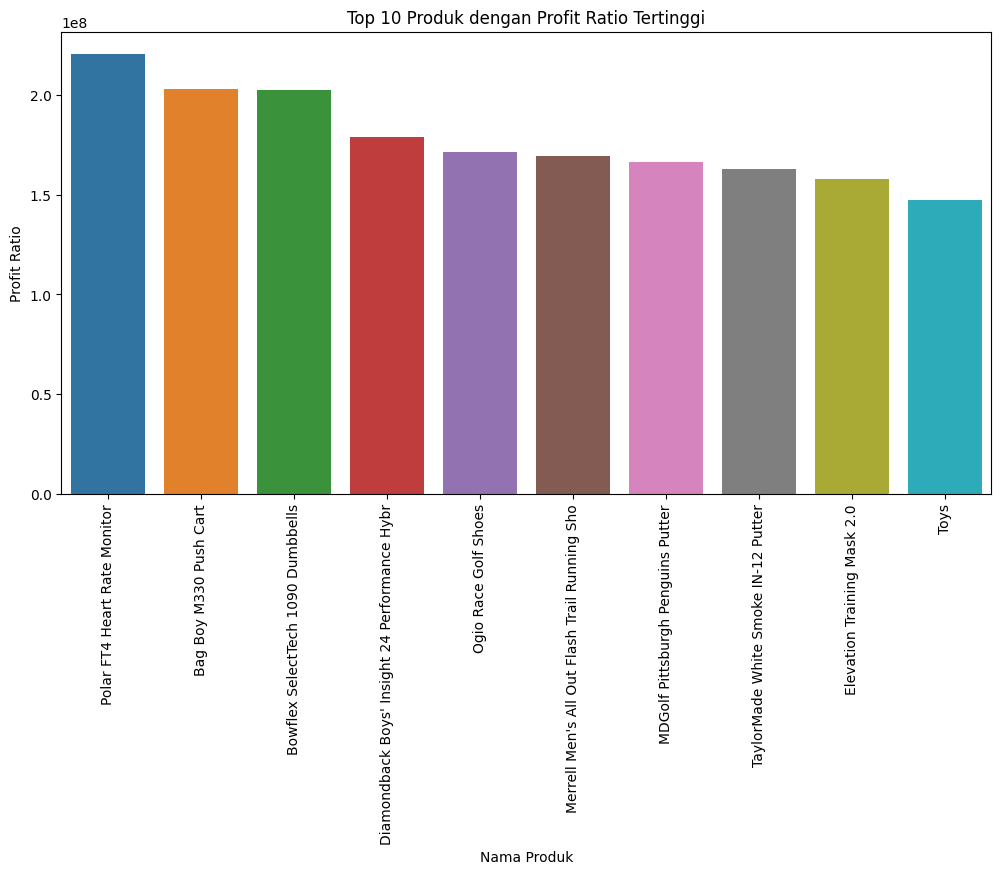

In [260]:
# Visualisasi Produk dengan Profit Ratio Tertinggi
plt.figure(figsize=(12,6))
sns.barplot(x=top_profit_product.index[:10], y=top_profit_product.values[:10])
plt.title('Top 10 Produk dengan Profit Ratio Tertinggi')
plt.xlabel('Nama Produk')
plt.ylabel('Profit Ratio')
plt.xticks(rotation=90)
plt.show()

In [233]:
top_customers = df.groupby('Customer Id')['Sales per customer'].sum().sort_values(ascending=False)

# Segmentasi Pelanggan berdasarkan Customer Segment
customer_segment_analysis = df.groupby('Customer Segment')['Sales per customer'].mean()

# Geografis Pelanggan: Distribusi pelanggan berdasarkan negara, kota, dan negara bagian
customer_country_distribution = df['Customer Country'].value_counts()
customer_city_distribution = df['Customer City'].value_counts()
customer_state_distribution = df['Customer State'].value_counts()

# Menampilkan hasil analisis
print(f"Top Customer ID: {top_customers.idxmax()} dengan total sales {top_customers.max():.2f}")
print(f"Segment Pelanggan Terbaik: {customer_segment_analysis.idxmax()} dengan rata-rata sales {customer_segment_analysis.max():.2f}")
print(f"Negara dengan Pelanggan Terbanyak: {customer_country_distribution.idxmax()}")
print(f"Kota dengan Pelanggan Terbanyak: {customer_city_distribution.idxmax()}")
print(f"Negara Bagian dengan Pelanggan Terbanyak: {customer_state_distribution.idxmax()}")

Top Customer ID: 10591 dengan total sales 140102421100.00
Segment Pelanggan Terbaik: Home Office dengan rata-rata sales 2236081182.12
Negara dengan Pelanggan Terbanyak: EE. UU.
Kota dengan Pelanggan Terbanyak: Caguas
Negara Bagian dengan Pelanggan Terbanyak: PR


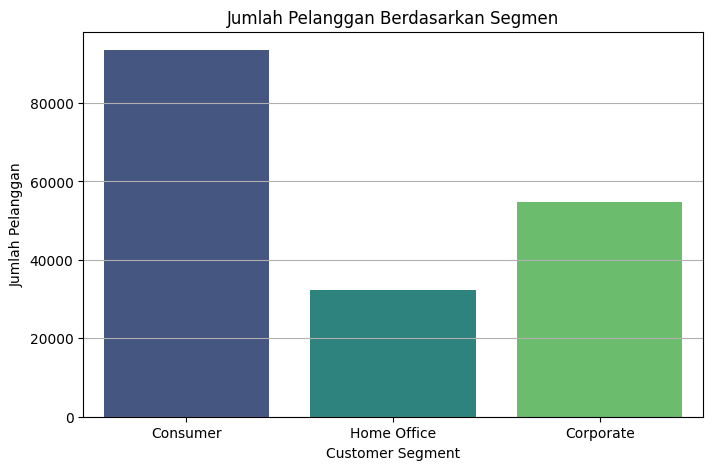

In [259]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='Customer Segment', palette="viridis")
plt.xlabel("Customer Segment")
plt.ylabel("Jumlah Pelanggan")
plt.title("Jumlah Pelanggan Berdasarkan Segmen")
plt.grid(axis='y')
plt.show()

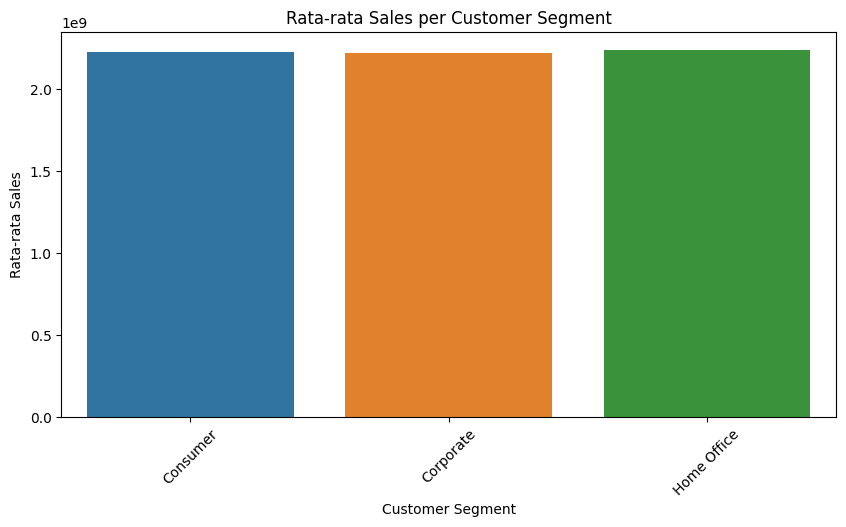

In [234]:
# Visualisasi Distribusi Pelanggan berdasarkan Segmen
plt.figure(figsize=(10,5))
sns.barplot(x=customer_segment_analysis.index, y=customer_segment_analysis.values)
plt.title('Rata-rata Sales per Customer Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Rata-rata Sales')
plt.xticks(rotation=45)
plt.show()

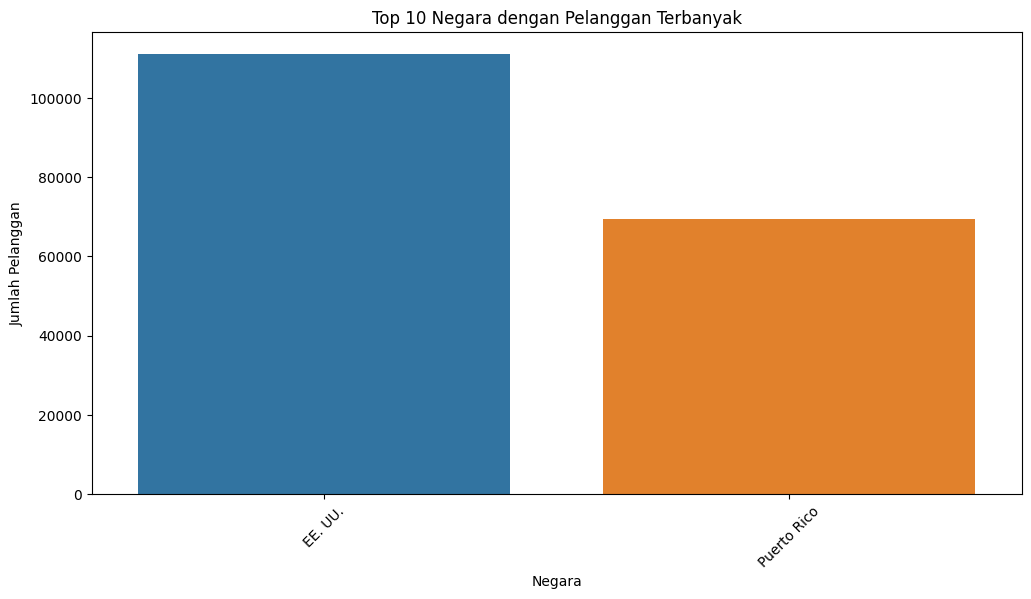

In [235]:
# Visualisasi Distribusi Pelanggan berdasarkan Negara
plt.figure(figsize=(12,6))
sns.barplot(x=customer_country_distribution.index[:10], y=customer_country_distribution.values[:10])
plt.title('Top 10 Negara dengan Pelanggan Terbanyak')
plt.xlabel('Negara')
plt.ylabel('Jumlah Pelanggan')
plt.xticks(rotation=45)
plt.show()

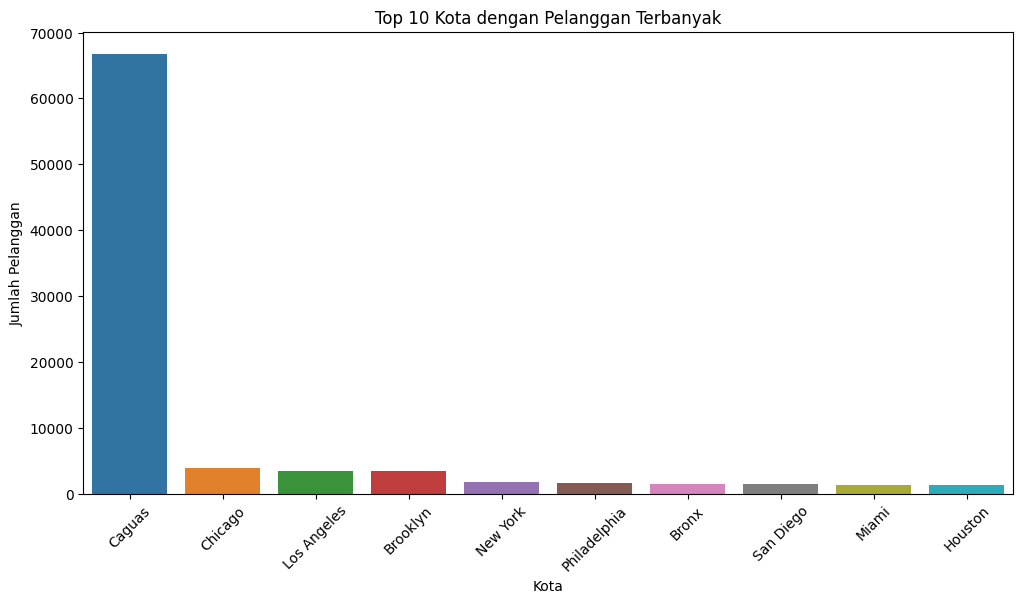

In [264]:
# Visualisasi Distribusi Pelanggan berdasarkan Kota
plt.figure(figsize=(12,6))
sns.barplot(x=customer_city_distribution.index[:10], y=customer_city_distribution.values[:10])
plt.title('Top 10 Kota dengan Pelanggan Terbanyak')
plt.xlabel('Kota')
plt.ylabel('Jumlah Pelanggan')
plt.xticks(rotation=45)
plt.show()

In [237]:
region_orders = df['Order Region'].value_counts()
country_orders = df['Order Country'].value_counts()

# Analisis Pasar berdasarkan Market
df['Sales per customer'] = pd.to_numeric(df['Sales per customer'], errors='coerce')
market_sales = df.groupby('Market')['Sales per customer'].sum().sort_values(ascending=False)

# Menampilkan hasil analisis
print(f"Wilayah dengan Pesanan Terbanyak: {region_orders.idxmax()} ({region_orders.max()} pesanan)")
print(f"Negara dengan Pesanan Terbanyak: {country_orders.idxmax()} ({country_orders.max()} pesanan)")
print(f"Pasar dengan Penjualan Terbesar: {market_sales.idxmax()} ({market_sales.max():.2f} total sales)")

Wilayah dengan Pesanan Terbanyak: Central America (28341 pesanan)
Negara dengan Pesanan Terbanyak: Estados Unidos (24840 pesanan)
Pasar dengan Penjualan Terbesar: LATAM (112891950602971.00 total sales)


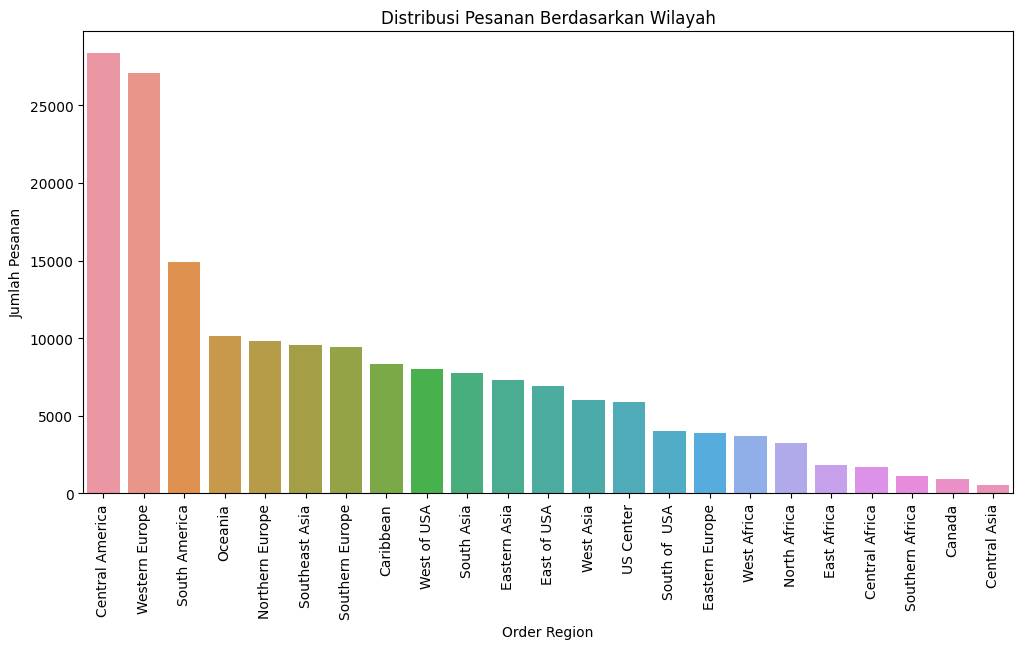

In [238]:
# Visualisasi Distribusi Pesanan Berdasarkan Wilayah
plt.figure(figsize=(12,6))
sns.barplot(x=region_orders.index, y=region_orders.values)
plt.title('Distribusi Pesanan Berdasarkan Wilayah')
plt.xlabel('Order Region')
plt.ylabel('Jumlah Pesanan')
plt.xticks(rotation=90)
plt.show()

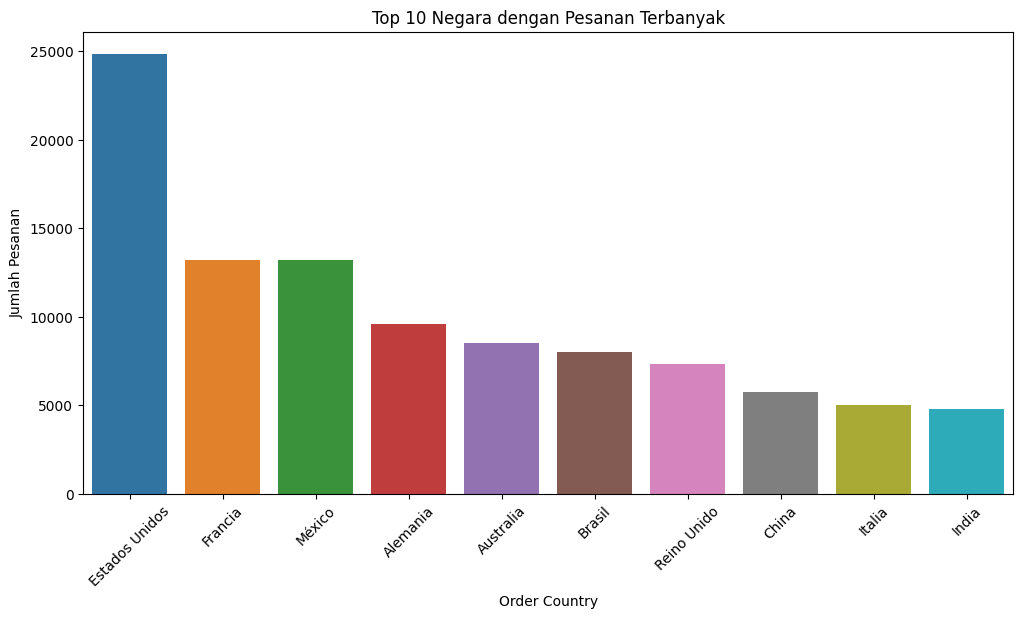

In [239]:
# Visualisasi Distribusi Pesanan Berdasarkan Negara
plt.figure(figsize=(12,6))
sns.barplot(x=country_orders.index[:10], y=country_orders.values[:10])
plt.title('Top 10 Negara dengan Pesanan Terbanyak')
plt.xlabel('Order Country')
plt.ylabel('Jumlah Pesanan')
plt.xticks(rotation=45)
plt.show()

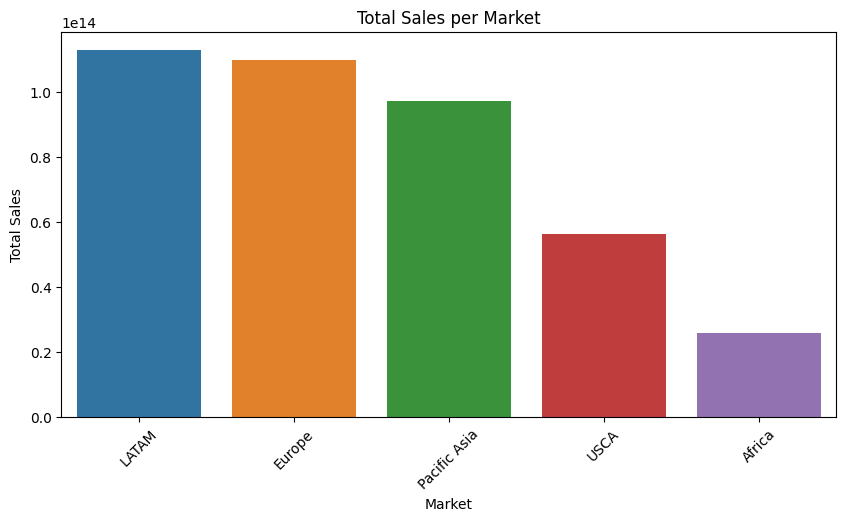

In [240]:
# Visualisasi Volume Penjualan Berdasarkan Market
plt.figure(figsize=(10,5))
sns.barplot(x=market_sales.index, y=market_sales.values)
plt.title('Total Sales per Market')
plt.xlabel('Market')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

Analisis performa produc

Produk Terlaris: Perfect Fitness Perfect Rip Deck dengan 73698 unit terjual
Kategori Terlaris: Cleats dengan 24551 pesanan
Produk dengan Keuntungan Tertinggi: Polar FT4 Heart Rate Monitor dengan profit ratio 220800000.45
Jumlah Produk yang Tidak Tersedia: 0


In [245]:
# Identifikasi Order Fraud (Order Status = 'SUSPECTED_FRAUD')
fraud_orders = df[df['Order Status'] == 'SUSPECTED_FRAUD'].shape[0]

# Analisis Order yang Dibatalkan (Order Status = 'CANCELED')
canceled_orders = df[df['Order Status'] == 'CANCELED'].shape[0]

# Pola Pembayaran: Menghitung jumlah PAYMENT_REVIEW dan PENDING_PAYMENT
payment_review_orders = df[df['Order Status'] == 'PAYMENT_REVIEW'].shape[0]
pending_payment_orders = df[df['Order Status'] == 'PENDING_PAYMENT'].shape[0]

# Hubungan PAYMENT_REVIEW & PENDING_PAYMENT dengan keterlambatan
payment_review_late = df[df['Order Status'] == 'PAYMENT_REVIEW']['Late_delivery_risk'].mean()
pending_payment_late = df[df['Order Status'] == 'PENDING_PAYMENT']['Late_delivery_risk'].mean()

# Menampilkan hasil analisis
print(f"Total Fraud Orders: {fraud_orders}")
print(f"Total Canceled Orders: {canceled_orders}")
print(f"Total Payment Review Orders: {payment_review_orders}")
print(f"Total Pending Payment Orders: {pending_payment_orders}")
print(f"Avg Late Delivery Risk (Payment Review): {payment_review_late:.2f}")
print(f"Avg Late Delivery Risk (Pending Payment): {pending_payment_late:.2f}")

# Visualisasi Distribusi Order Status terkait Fraud & Pembatalan
fraud_cancel_data = df['Order Status'].value_counts()[['SUSPECTED_FRAUD', 'CANCELED', 'PAYMENT_REVIEW', 'PENDING_PAYMENT']]

Total Fraud Orders: 4062
Total Canceled Orders: 3692
Total Payment Review Orders: 1893
Total Pending Payment Orders: 39832
Avg Late Delivery Risk (Payment Review): 0.57
Avg Late Delivery Risk (Pending Payment): 0.58


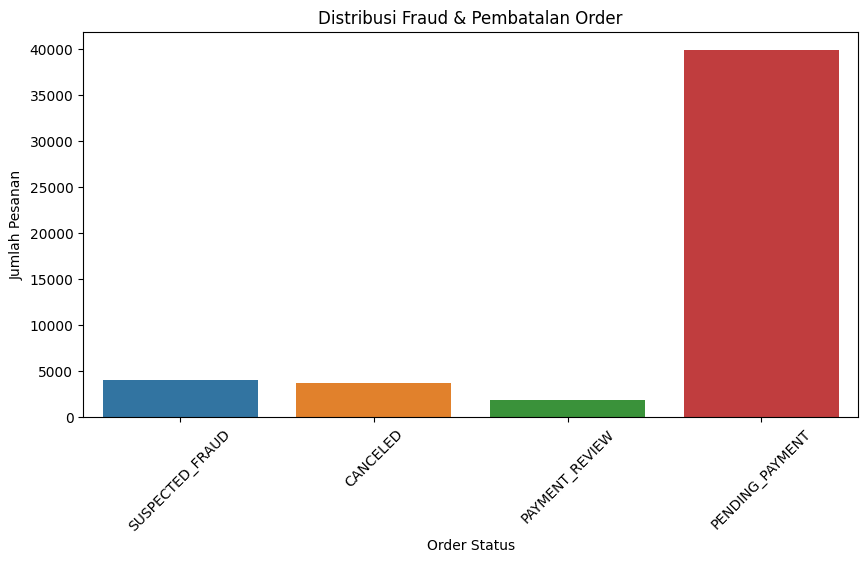

In [246]:
plt.figure(figsize=(10,5))
sns.barplot(x=fraud_cancel_data.index, y=fraud_cancel_data.values)
plt.title('Distribusi Fraud & Pembatalan Order')
plt.xlabel('Order Status')
plt.ylabel('Jumlah Pesanan')
plt.xticks(rotation=45)
plt.show()

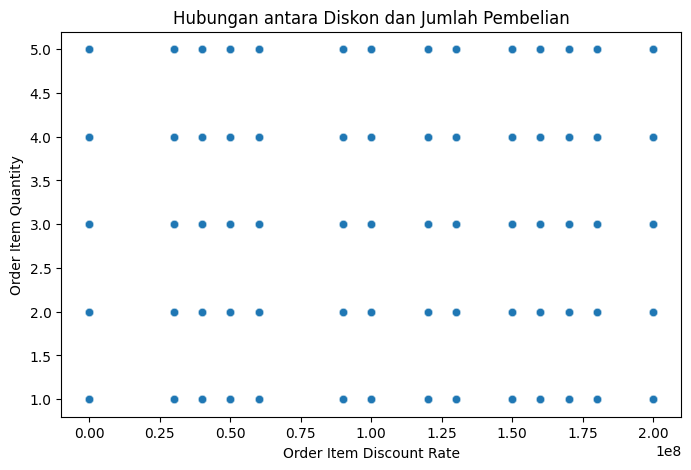

In [248]:
# Visualisasi hubungan antara Diskon dan Jumlah Pembelian
plt.figure(figsize=(8,5))
sns.scatterplot(x=df['Order Item Discount Rate'], y=df['Order Item Quantity'], alpha=0.5)
plt.title('Hubungan antara Diskon dan Jumlah Pembelian')
plt.xlabel('Order Item Discount Rate')
plt.ylabel('Order Item Quantity')
plt.show()

Model Accuracy: 97.49%


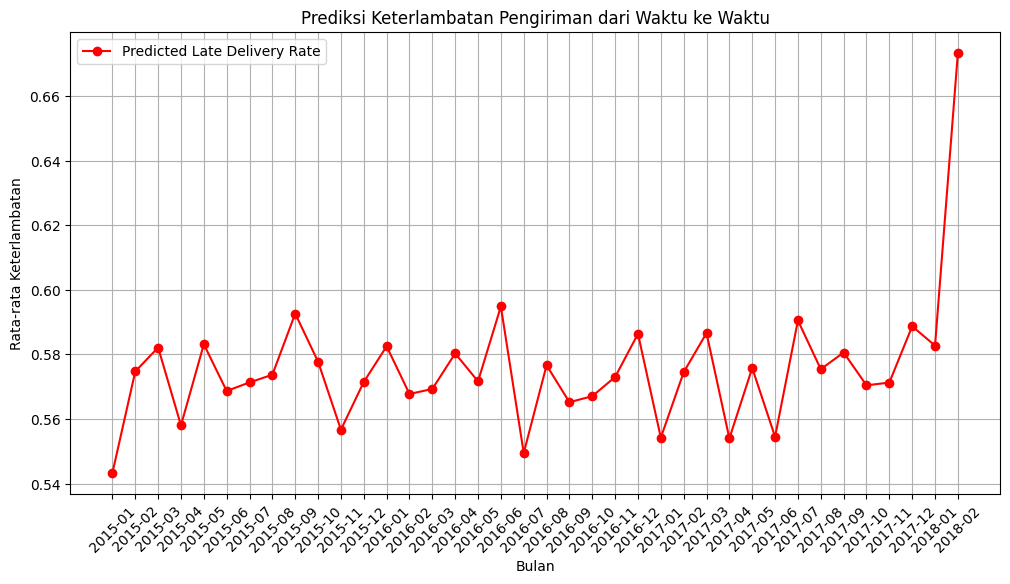

In [255]:
features = ['Days for shipment (scheduled)', 'Days for shipping (real)']
X = df[features]
y = df['Late_delivery_risk']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Random Forest Classifier
model_late_delivery = RandomForestClassifier(n_estimators=100, random_state=42)
model_late_delivery.fit(X_train, y_train)

# Prediksi
y_pred = model_late_delivery.predict(X_test)

# Evaluasi model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2%}")

# Prediksi keterlambatan berdasarkan waktu (Time Series)
df['Predicted Late Delivery'] = model_late_delivery.predict(X)

# Agregasi keterlambatan berdasarkan bulan
late_delivery_trend = df.groupby(df['Order Date'].dt.to_period("M"))['Predicted Late Delivery'].mean()

# Visualisasi Prediksi Keterlambatan Pengiriman dalam Time Series
plt.figure(figsize=(12,6))
plt.plot(late_delivery_trend.index.astype(str), late_delivery_trend.values, marker='o', linestyle='-', color='red', label='Predicted Late Delivery Rate')
plt.title('Prediksi Keterlambatan Pengiriman dari Waktu ke Waktu')
plt.xlabel('Bulan')
plt.ylabel('Rata-rata Keterlambatan')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

Mean Absolute Error: 1402.68
    Year  Month  Predicted Order Quantity
0   2018      1                   4687.41
1   2018      2                   4593.27
2   2018      3                   4587.03
3   2018      4                   4780.91
4   2018      5                   4847.44
5   2018      6                   4676.62
6   2018      7                   4685.57
7   2018      8                   4808.07
8   2018      9                   4517.21
9   2018     10                   4264.57
10  2018     11                   2382.54
11  2018     12                   2068.36


<ipython-input-253-53516f36390d>:49: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(start=f"{latest_year}-01-01", periods=12, freq='M'), future_predictions_from_latest, label="Predicted Orders", linestyle="dashed", color='red')


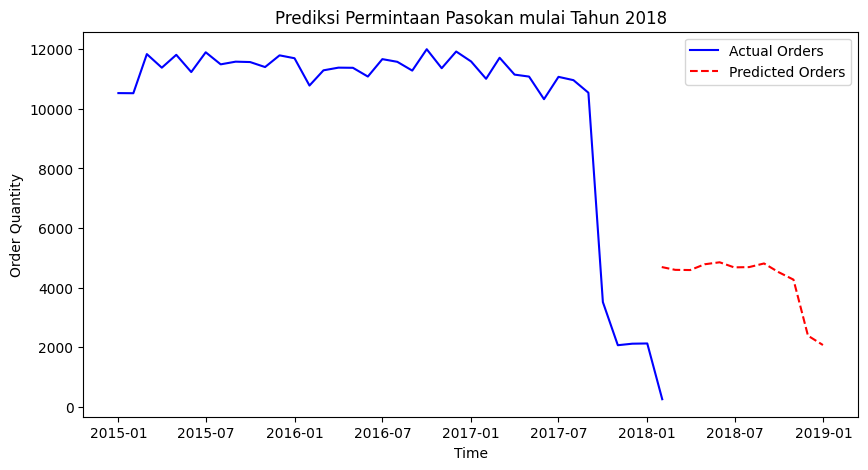

In [253]:
df['Order Date'] = pd.to_datetime(df['shipping date (DateOrders)'], errors='coerce')

# Agregasi jumlah order berdasarkan bulan
df_orders = df.groupby(df['Order Date'].dt.to_period("M"))['Order Item Quantity'].sum().reset_index()
df_orders['Order Date'] = df_orders['Order Date'].astype(str)  # Konversi ke string
df_orders['Order Date'] = pd.to_datetime(df_orders['Order Date'])

# Menyiapkan dataset untuk model
df_orders['Month'] = df_orders['Order Date'].dt.month
df_orders['Year'] = df_orders['Order Date'].dt.year
X = df_orders[['Year', 'Month']]
y = df_orders['Order Item Quantity']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluasi model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.2f}")

# Menentukan tahun terakhir dalam dataset
latest_year = df['Order Date'].dt.year.max()

# Menyiapkan dataset untuk prediksi permintaan mulai dari tahun terakhir
future_months_from_latest = pd.DataFrame({
    'Year': [latest_year] * 12,  # Prediksi mulai dari tahun terakhir
    'Month': list(range(1, 13))
})

# Melakukan prediksi
future_predictions_from_latest = model.predict(future_months_from_latest)

# Menampilkan hasil prediksi
future_predictions_df = pd.DataFrame({
    'Year': future_months_from_latest['Year'],
    'Month': future_months_from_latest['Month'],
    'Predicted Order Quantity': future_predictions_from_latest
})
print(future_predictions_df)

# Visualisasi prediksi
plt.figure(figsize=(10,5))
plt.plot(df_orders['Order Date'], df_orders['Order Item Quantity'], label="Actual Orders", color="blue")
plt.plot(pd.date_range(start=f"{latest_year}-01-01", periods=12, freq='M'), future_predictions_from_latest, label="Predicted Orders", linestyle="dashed", color='red')
plt.xlabel('Time')
plt.ylabel('Order Quantity')
plt.title(f'Prediksi Permintaan Pasokan mulai Tahun {latest_year}')
plt.legend()
plt.show()

Hasil Optimasi Rantai Pasok dan Logistik:
       Order Region  Optimized Supply Allocation
0            Canada                          0.0
1         Caribbean                          0.0
2    Central Africa                          0.0
3   Central America                          0.0
4      Central Asia                          0.0
5       East Africa                          0.0
6       East of USA                          0.0
7      Eastern Asia                          0.0
8    Eastern Europe                          0.0
9      North Africa                          0.0
10  Northern Europe                          0.0
11          Oceania                          0.0
12    South America                          0.0
13       South Asia                          0.0
14    South of  USA                          0.0
15   Southeast Asia                     384079.0
16  Southern Africa                          0.0
17  Southern Europe                          0.0
18        US Center        

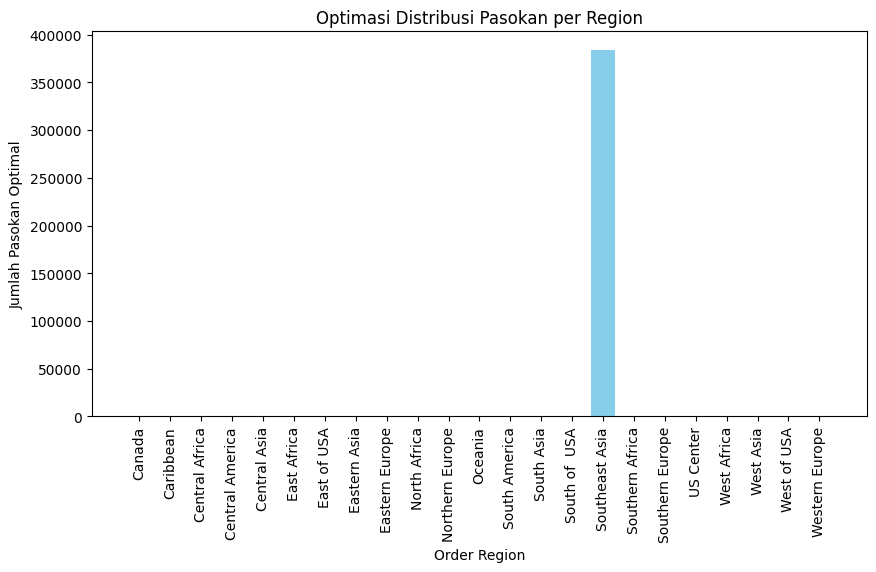

In [258]:
import scipy.optimize as opt
supply_demand = df.groupby(['Order Region'])[['Order Item Quantity']].sum().reset_index()

# Simulasi biaya pengiriman dengan proxy dari Product Price (rata-rata per region)
avg_shipping_cost = df.groupby('Order Region')['Product Price'].mean().reset_index()
supply_demand = supply_demand.merge(avg_shipping_cost, on='Order Region', how='left')

# Menyiapkan data untuk linear programming
regions = supply_demand['Order Region'].unique()
supply = supply_demand['Order Item Quantity'].values  # Kapasitas per region
costs = supply_demand['Product Price'].values  # Biaya pengiriman estimasi
total_demand = supply.sum()  # Total permintaan global

# Menyusun constraint
A_eq = [np.ones(len(supply))]  # Total distribusi harus sama dengan total demand
b_eq = [total_demand]

# Menjalankan optimasi menggunakan linear programming
res = opt.linprog(costs, A_eq=A_eq, b_eq=b_eq, bounds=[(0, None)] * len(supply), method='highs')

# Menampilkan hasil optimasi
if res.success:
    optimized_distribution = np.array(res.x)
    result_optimization = pd.DataFrame({
        'Order Region': regions,
        'Optimized Supply Allocation': optimized_distribution
    })
    print("Hasil Optimasi Rantai Pasok dan Logistik:")
    print(result_optimization)
    print(f"\nTotal Biaya Minimum: {res.fun:.2f}")

    # Visualisasi distribusi optimal
    plt.figure(figsize=(10,5))
    plt.bar(regions, optimized_distribution, color='skyblue')
    plt.title('Optimasi Distribusi Pasokan per Region')
    plt.xlabel('Order Region')
    plt.ylabel('Jumlah Pasokan Optimal')
    plt.xticks(rotation=90)
    plt.show()
else:
    print("Optimasi gagal ditemukan.")